#### BERT

https://www.youtube.com/watch?v=RgpANRh44ao

In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

In [18]:
final_train_none_augmented = pd.read_csv('final_train_none_augmented.csv')
original_train_data = pd.read_csv('original_train_data.csv')
original_train_data.drop(columns = 'reiss', inplace = True)
original_train_data['maslow'] = original_train_data['maslow'].replace(['physiological','love','stability','esteem','spiritual growth','none'],['need','need','need','need','need','no need'])
final_train_none_augmented['maslow'] = final_train_none_augmented['maslow'].replace(['none'],['no need'])
final_train_data = pd.concat([original_train_data,final_train_none_augmented])
final_train_data = final_train_data.drop_duplicates(subset=['sentence'],keep = 'last')
final_train_data[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
need,14440
no need,5528


In [20]:
original_train_data[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
need,14440
no need,2034


In [41]:
# Undersampling Need Category

from sklearn.utils import shuffle
need_category = final_train_data[final_train_data['maslow'] == 'need']
need_category = need_category.reset_index()
need_category = need_category[['sentence','maslow']]
need_category = need_category.iloc[0:5528][:]
final_train_data = pd.concat([need_category,final_train_none_augmented])
final_train_data = final_train_data.drop_duplicates(subset=['sentence'],keep = 'last')
final_train_data = shuffle(final_train_data)
final_train_data = final_train_data.reset_index()
final_train_data = final_train_data[['sentence','maslow']]
final_train_data[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
need,5528
no need,5528


In [46]:
df_train = final_train_data
df_test = pd.read_csv('original_test_data.csv')
df_test['maslow'] = df_test['maslow'].replace(['physiological','love','stability','esteem','spiritual growth','none'],['need','need','need','need','need','no need'])
df_test = df_test[['sentence','maslow']]
df_train = df_train[['sentence','maslow']]
df_train.head()

,sentence,maslow
0,A small spark created a fire in the kitchen.Th...,no need
1,Karina just got new blocks to play with.,need
2,My friend Tim and I played speed chess tonight...,need
3,I received a phone call at work from a new con...,need
4,Kevin had a classic 1969 convertible that need...,need


In [47]:
df_test.tail()

,sentence,maslow
4114,Candy heard that her very favorite band was pl...,need
4115,"Morgan loved riding her bicycle.One day, she r...",need
4116,My father liked to eat oysters.One day he brou...,no need
4117,"When I was a boy, I rode my bike down a local ...",no need
4118,Jules wanted to cook for her family.She decide...,need


In [48]:
!pip install text_hammer
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 4.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.6 MB/s 
     |████████████████████████████████| 120 kB 57.3 MB/s 
     |████████████████████████████████| 6.6 MB 54.0 MB/s 


In [49]:
from tqdm._tqdm_notebook import tqdm_notebook 
import text_hammer as th
tqdm_notebook.pandas()

def text_preprocessing(df, column_name):
    column = column_name 
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    return(df)
df_train_cleaned = text_preprocessing(df_train,'sentence')
df_test_cleaned = text_preprocessing(df_test,'sentence')

  0%|          | 0/11056 [00:00<?, ?it/s]

  0%|          | 0/11056 [00:00<?, ?it/s]

  0%|          | 0/11056 [00:00<?, ?it/s]

  0%|          | 0/11056 [00:00<?, ?it/s]

  0%|          | 0/11056 [00:00<?, ?it/s]

  0%|          | 0/11056 [00:00<?, ?it/s]

  0%|          | 0/4119 [00:00<?, ?it/s]

  0%|          | 0/4119 [00:00<?, ?it/s]

  0%|          | 0/4119 [00:00<?, ?it/s]

  0%|          | 0/4119 [00:00<?, ?it/s]

  0%|          | 0/4119 [00:00<?, ?it/s]

  0%|          | 0/4119 [00:00<?, ?it/s]

In [50]:
df_train_cleaned.head()

,sentence,maslow
0,a small spark created a fire in the kitchenthe...,no need
1,karina just got new blocks to play with,need
2,my friend tim and i played speed chess tonight...,need
3,i received a phone call at work from a new con...,need
4,kevin had a classic 1969 convertible that need...,need


In [51]:
df_test_cleaned.head()

,sentence,maslow
0,jamies job requires her to travel a lotshe has...,need
1,andy was craving some cerealhe picked out some...,need
2,karl locked his car,need
3,i was bullied in high schooli had one bully in...,need
4,kay was at work when a headache started,need


In [52]:
df_cleaned = df_train_cleaned.copy()

In [53]:
df_cleaned['num_words'] = df_cleaned.sentence.apply(lambda x:len(x.split()))
df_cleaned.head()

,sentence,maslow,num_words
0,a small spark created a fire in the kitchenthe...,no need,27
1,karina just got new blocks to play with,need,8
2,my friend tim and i played speed chess tonight...,need,18
3,i received a phone call at work from a new con...,need,26
4,kevin had a classic 1969 convertible that need...,need,43


In [54]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11056 entries, 0 to 11055
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11056 non-null  object
 1   maslow     11056 non-null  object
 2   num_words  11056 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 259.2+ KB


In [55]:
df_cleaned['maslow'] = df_cleaned.maslow.astype('category')
df_test_cleaned['maslow'] = df_test_cleaned.maslow.astype('category')
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11056 entries, 0 to 11055
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sentence   11056 non-null  object  
 1   maslow     11056 non-null  category
 2   num_words  11056 non-null  int64   
dtypes: category(1), int64(1), object(1)
memory usage: 183.8+ KB


In [56]:
print(df_cleaned.maslow.unique())

['no need', 'need']
Categories (2, object): ['need', 'no need']


In [57]:
df_cleaned.maslow

0        no need
1           need
2           need
3           need
4           need
          ...   
11051    no need
11052    no need
11053    no need
11054    no need
11055    no need
Name: maslow, Length: 11056, dtype: category
Categories (2, object): ['need', 'no need']

In [58]:
print(df_cleaned.maslow.cat.codes)

0        1
1        0
2        0
3        0
4        0
        ..
11051    1
11052    1
11053    1
11054    1
11055    1
Length: 11056, dtype: int8


In [60]:
#encoded_dict = {'esteem':0, 'love':1, 'none':2, 'physiological':3, 'spiritual growth':4, 'stability':5}
encoded_dict = {'need':0, 'no need':1}
df_cleaned['maslow'] = df_cleaned.maslow.cat.codes
df_test_cleaned['maslow'] = df_test_cleaned.maslow.cat.codes
df_cleaned.maslow

0        1
1        0
2        0
3        0
4        0
        ..
11051    1
11052    1
11053    1
11054    1
11055    1
Name: maslow, Length: 11056, dtype: int8

In [61]:
df_cleaned.head()

,sentence,maslow,num_words
0,a small spark created a fire in the kitchenthe...,1,27
1,karina just got new blocks to play with,0,8
2,my friend tim and i played speed chess tonight...,0,18
3,i received a phone call at work from a new con...,0,26
4,kevin had a classic 1969 convertible that need...,0,43


In [62]:
df_test_cleaned.head()

,sentence,maslow
0,jamies job requires her to travel a lotshe has...,0
1,andy was craving some cerealhe picked out some...,0
2,karl locked his car,0
3,i was bullied in high schooli had one bully in...,0
4,kay was at work when a headache started,0


In [63]:
df_cleaned.num_words.max()

64

In [64]:
from sklearn.model_selection import train_test_split
data_train = df_cleaned
data_test = df_test_cleaned
print(data_train.shape)
print(data_test.shape)

(11056, 3)
(4119, 2)


In [65]:
from tensorflow.keras.utils import to_categorical
to_categorical(data_train.maslow)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [66]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

In [ ]:
#import shutil 
#shutil.make_archive('bert-tokenizer','zip','bert-tokenizer')
#shutil.make_archive('bert-model','zip','bert-model')

In [ ]:
#from transformers import BertTokenizer, TFBertModel, BertConfig, TFDistilBertModel, DistilBertTokenizer, DistilBertConfig
#dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [67]:
x_train = tokenizer(
    text = data_train.sentence.tolist(),
    add_special_tokens = True,
    max_length = 70,
    truncation = True,
    padding = True, 
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True, 
    verbose = True
)

x_test = tokenizer(
    text = data_test.sentence.tolist(),
    add_special_tokens = True,
    max_length = 70,
    truncation = True,
    padding = True, 
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True, 
    verbose = True
)

In [68]:
x_train

{'input_ids': <tf.Tensor: shape=(11056, 70), dtype=int32, numpy=
array([[  101,   170,  1353, ...,     0,     0,     0],
       [  101, 24181,  9324, ...,     0,     0,     0],
       [  101,  1139,  1910, ...,     0,     0,     0],
       ...,
       [  101,  1821, 16724, ...,     0,     0,     0],
       [  101,   170,  8376, ...,     0,     0,     0],
       [  101,  1940, 20492, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(11056, 70), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [69]:
x_test

{'input_ids': <tf.Tensor: shape=(4119, 70), dtype=int32, numpy=
array([[  101, 17462,  1905, ...,     0,     0,     0],
       [  101,  1105,  1183, ...,     0,     0,     0],
       [  101, 24181, 17670, ...,     0,     0,     0],
       ...,
       [  101,  1139,  1401, ...,     0,     0,     0],
       [  101,  1165,   178, ...,     0,     0,     0],
       [  101,   179, 11806, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4119, 70), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [70]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.initializers import TruncatedNormal 
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf 
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [71]:
max_len = 70 
input_ids = Input(shape = (max_len,), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len,), dtype = tf.int32, name = 'attention_mask') 
embeddings = bert(input_ids, attention_mask = input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation = 'relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation = 'relu')(out)
y = Dense(2, activation = 'sigmoid')(out)
model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)
model.layers[2].trainable = True

In [72]:
model.layers

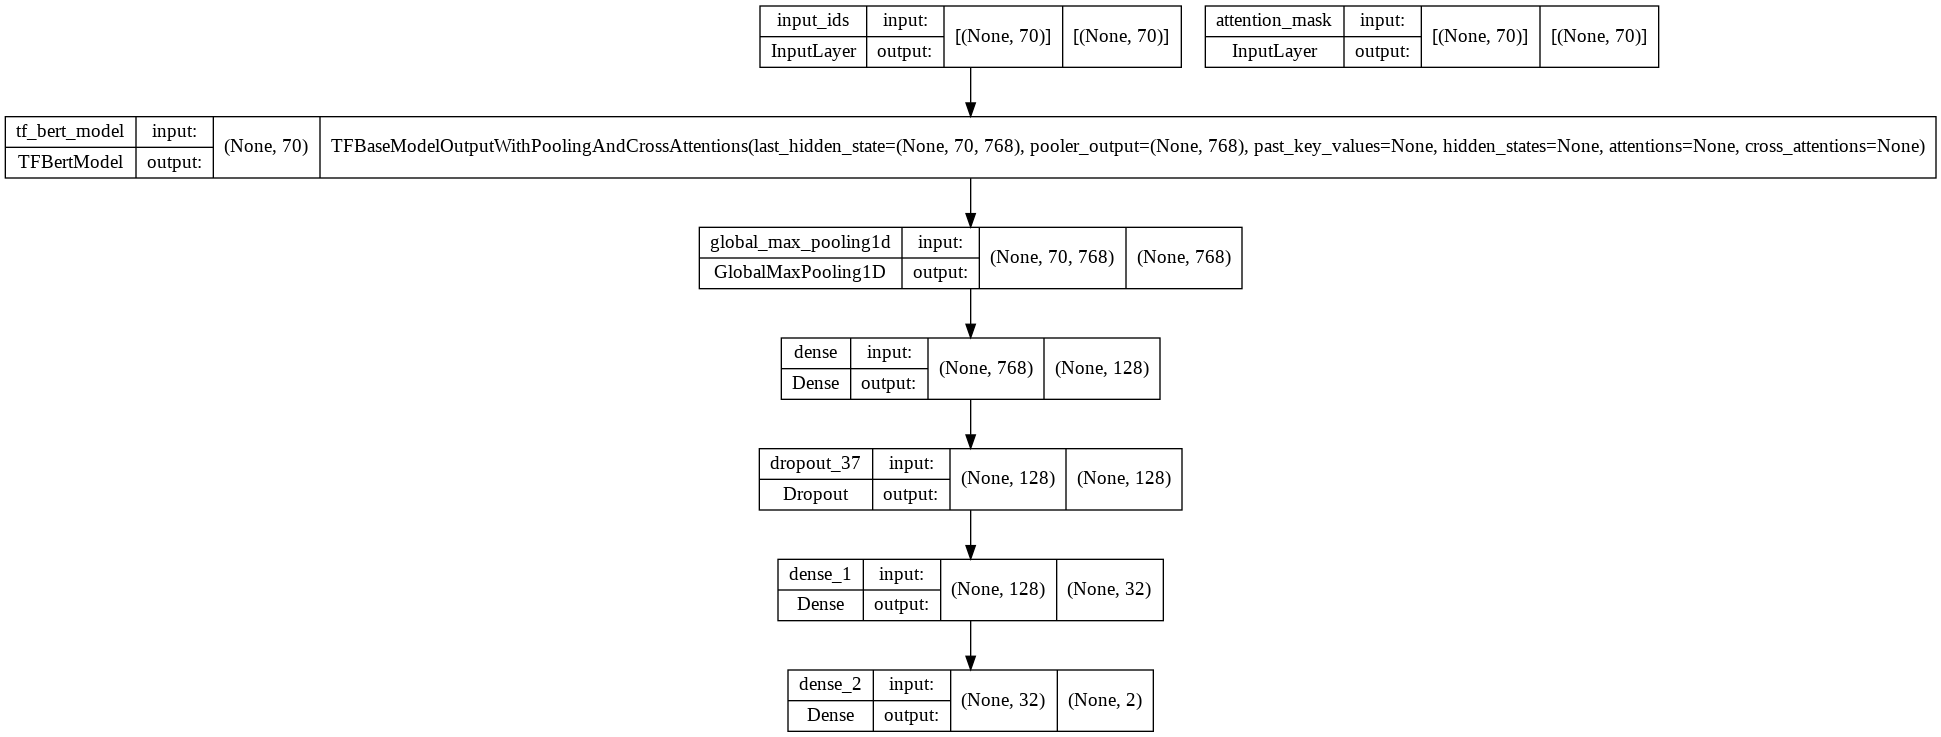

In [73]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [74]:
optimizer = Adam(
    learning_rate = 5e-05,
    epsilon = 1e-08,
    decay = 0.01,
    clipnorm = 1.0
)

#loss = CategoricalCrossentropy() 
metric = CategoricalAccuracy('balanced_accuracy')
model.compile(optimizer = optimizer, loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), metrics = metric)

In [75]:
#tf.config.experimental_run_functions_eagerly(True)
#tf.config.run_functions_eagerly(True)

In [77]:
for i in range(5):
    answer = int(input("Do you want to run another epoch?1/0: "))
    if answer == 1:
        train_history = model.fit(x = {'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
                            y = to_categorical(data_train.maslow),
                            validation_data = (
                                {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, to_categorical(data_test.maslow)
                            ),
                            epochs = 5,
                            batch_size = 36,
                            )
    else:
        break

Do you want to run another epoch?1/0: 1
Epoch 1/5


308/308 [==============================] - 196s 564ms/step - loss: 0.6278 - balanced_accuracy: 0.6399 - val_loss: 0.6338 - val_balanced_accuracy: 0.6414
Epoch 2/5
308/308 [==============================] - 179s 582ms/step - loss: 0.4755 - balanced_accuracy: 0.7789 - val_loss: 0.5298 - val_balanced_accuracy: 0.7434
Epoch 3/5
308/308 [==============================] - 180s 585ms/step - loss: 0.3323 - balanced_accuracy: 0.8597 - val_loss: 0.5860 - val_balanced_accuracy: 0.7478
Epoch 4/5
308/308 [==============================] - 180s 586ms/step - loss: 0.2297 - balanced_accuracy: 0.9105 - val_loss: 0.8066 - val_balanced_accuracy: 0.6878
Epoch 5/5
308/308 [==============================] - 180s 586ms/step - loss: 0.1701 - balanced_accuracy: 0.9370 - val_loss: 0.7241 - val_balanced_accuracy: 0.7618
Do you want to run another epoch?1/0: 0


In [88]:
predicted_raw = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}) 
predicted_raw[0]

array([0.9735304 , 0.09643597], dtype=float32)

In [104]:
y_predicted = np.argmax(predicted_raw, axis = 1)

In [105]:
data_test['predmaslow'] = y_predicted

In [106]:
data_test

,sentence,maslow,predmaslow
0,jamies job requires her to travel a lotshe has...,0,0
1,andy was craving some cerealhe picked out some...,0,0
2,karl locked his car,0,0
3,i was bullied in high schooli had one bully in...,0,1
4,kay was at work when a headache started,0,1
...,...,...,...
4114,candy heard that her very favorite band was pl...,0,0
4115,morgan loved riding her bicycleone day she rod...,0,1
4116,my father liked to eat oystersone day he broug...,1,0
4117,when i was a boy i rode my bike down a local h...,1,0


In [107]:
from sklearn.metrics import classification_report
data_test.head()
uniqueClassesMaslowLabel2 = ['need','no need']
uniqueClassesMaslow2 = [0,1]
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)
print(classification_report(data_test['predmaslow'], data_test['maslow'],target_names = uniqueClassesMaslowLabel2))

['need', 'no need']
[0, 1]
              precision    recall  f1-score   support

        need       0.82      0.90      0.86      3281
     no need       0.36      0.22      0.27       838

    accuracy                           0.76      4119
   macro avg       0.59      0.56      0.56      4119
weighted avg       0.73      0.76      0.74      4119



[[2955  326]
 [ 655  183]]


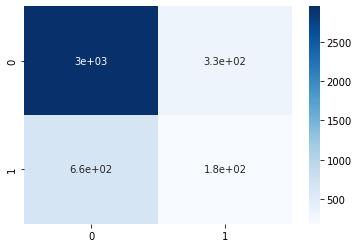

In [108]:
import seaborn as sns
import sklearn
r2 = sklearn.metrics.confusion_matrix(y_predicted, data_test.maslow)
print(r2)
ax = sns.heatmap(r2, annot=True, cmap='Blues')

In [109]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

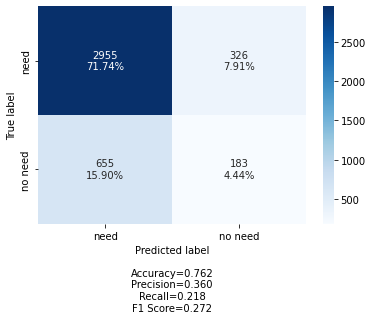

In [110]:
import matplotlib.pyplot as plt
number = [0,1]
category = ['need','no need']
make_confusion_matrix(r2, group_names=number, categories=category, cmap='Blues')

In [111]:
def get_mistakes(prediction_values, actual_values, test_sentences, actual_category, predicted_category,samples_shown):
    # Make sure you Map uniqueClassesMaslowLabell2 catgory with the labels mapping as index. If label is 0 then the category index in the list should be 0
    count = 0
    correct_index = uniqueClassesMaslowLabel2.index(actual_category)
    incorrect_index = uniqueClassesMaslowLabel2.index(predicted_category)
    print('Text classified as ',uniqueClassesMaslowLabel2[incorrect_index]," but actual category is ",uniqueClassesMaslowLabel2[correct_index])
    for i in range(0,len(prediction_values)):
        if prediction_values[i] == incorrect_index and actual_values[i] == correct_index and count != samples_shown:
            print(str(i),test_sentences[i])
            count = count + 1

   
get_mistakes(prediction_values = list(y_predicted),
             actual_values = list(data_test['predmaslow']),
             test_sentences = list(data_test['sentence']),
             actual_category = 'no need', 
             predicted_category = 'need',
             samples_shown = 10)

Text classified as  need  but actual category is  no need


In [139]:
data_test_noneed_pred_as_need = data_test[data_test['maslow'] == 1]
data_test_noneed_pred_as_need = data_test_noneed_pred_as_need[data_test_noneed_pred_as_need['predmaslow'] == 0]
data_test_noneed_pred_as_need = data_test_noneed_pred_as_need.reset_index()
data_test_noneed_pred_as_need = data_test_noneed_pred_as_need[['sentence','maslow','predmaslow']]
data_test_noneed_pred_as_need.head(10)

,sentence,maslow,predmaslow
0,kay was taking piano lessonsher teacher was an...,1,0
1,tim was never good with dates,1,0
2,tammy wanted a new puppy,1,0
3,joe went to the bank to apply for a loan,1,0
4,lloyd was out partying one nighthe was having ...,1,0
5,amy was looking in her cupboardsshe did not ha...,1,0
6,cora wanted to get a new dress,1,0
7,tom gave me a shirt for my birthdayi thought t...,1,0
8,millys class was learning about alternative me...,1,0
9,mitch is playing basketballwhile driving to th...,1,0


In [141]:
print('noneed_but_pred_as_need')
for i in range(0,10):
    print(data_test_noneed_pred_as_need.iloc[i][0])

noneed_but_pred_as_need
kay was taking piano lessonsher teacher was an accomplished musiciankay was working on a piece to perform at the annual recitalshe learned a lot from her teacher
tim was never good with dates
tammy wanted a new puppy
joe went to the bank to apply for a loan
lloyd was out partying one nighthe was having a great timehe was also drinking a little too much
amy was looking in her cupboardsshe did not have anything to eat
cora wanted to get a new dress
tom gave me a shirt for my birthdayi thought the shirt was very ugly and not my stylemarys birthday was coming up next monthi put the shirt back in the box and rewrapped it
millys class was learning about alternative medicinethey visited an acupuncturist to learn more about itmilly was shocked by how long the needles werethe practitioner asked for a volunteer to have a needle insertedmilly moved to the back of the line to make sure he did not pick her
mitch is playing basketballwhile driving to the hoop to make a dunkhe